# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
from bizdays import Calendar
from matplotlib.ticker import MaxNLocator

cal = Calendar.load("ANBIMA")
maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [2]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\DGS2.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [3]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [4]:
data = data[data["mdate"] <= pd.Period("2023-07")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [5]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [6]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [7]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-04-01,2000-04-04,18.4837,NaN
2000-04-01,2000-04-05,18.7000,0.2163
2000-04-01,2000-04-06,18.8277,0.1277
2000-04-01,2000-04-07,18.6444,-0.1833
2000-04-01,2000-04-08,18.6444,0.0000


Save the resulting DataFrame to a new file

In [8]:
data.to_pickle("temp.pkl")

## 2. Adding COPOM dates

Load the COPOM dates from the Excel file

In [9]:
copom_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Brasil/BRW/COPOMdate.xlsx")
copom_dates.rename(columns={"date": "COPOM_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [10]:
dias_uteis = 5
iv2 = 2
iv7 = 7

copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates = copom_dates[copom_dates['COPOM_date'] >= pd.Period("2001-01-01").to_timestamp()]
copom_dates['COPOM_date'] = cal.offset(copom_dates['COPOM_date'],1)
instrumento = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],dias_uteis),'q':0})
instrumento_day2 = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],iv2),'q':2})
instrumento_iv2 = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],iv7),'q':3})

copom_dates = pd.concat([copom_dates, instrumento,instrumento_day2,instrumento_iv2])
copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates["year"] = copom_dates["COPOM_date"].dt.year
copom_dates["month"] = copom_dates["COPOM_date"].dt.month
copom_dates["day"] = copom_dates["COPOM_date"].dt.day
copom_dates["mdate"] = copom_dates["COPOM_date"].dt.to_period("M")


Drop unnecessary columns

In [11]:
copom_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [12]:
temp_data = pd.read_pickle("temp.pkl")

In [13]:
copom_dates.sort_values("COPOM_date")

,COPOM_date,q,mdate
54,2001-01-18,1,2001-01
0,2001-01-22,2,2001-01
0,2001-01-25,0,2001-01
0,2001-01-29,3,2001-01
55,2001-02-15,1,2001-02
...,...,...,...
198,2023-04-03,3,2023-04
253,2023-05-04,1,2023-05
199,2023-05-08,2,2023-05
199,2023-05-11,0,2023-05


Merge the two DataFrames on the 'date' column

In [14]:
merged_data = pd.merge(temp_data, copom_dates, how="inner", left_on="date", right_on="COPOM_date")

Drop rows where 'q' is missing (denoted as NaN)

In [15]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [16]:
merged_data["q"].fillna(0, inplace=True)
merged_data

,date,DGS2,dgs_d,COPOM_date,q,mdate
0,2001-01-18,15.9121,-0.1365,2001-01-18,1,2001-01
1,2001-01-22,15.8581,-0.0069,2001-01-22,2,2001-01
2,2001-01-25,15.6341,-0.0425,2001-01-25,0,2001-01
3,2001-01-29,15.4509,-0.0706,2001-01-29,3,2001-01
4,2001-02-15,15.9326,0.1250,2001-02-15,1,2001-02
...,...,...,...,...,...,...
795,2023-04-03,12.7632,-0.0186,2023-04-03,3,2023-04
796,2023-05-04,12.6881,0.0000,2023-05-04,1,2023-05
797,2023-05-08,12.5413,-0.0387,2023-05-08,2,2023-05
798,2023-05-11,12.5724,-0.0436,2023-05-11,0,2023-05


Save the merged DataFrame to a new file

In [17]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "svensson_br.xlsx" 

In [18]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\svensson_br.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [19]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [20]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

In [21]:
yield_data.head()

,date,mdate,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
0,2006-01-02,2006-01,16.603599,16.069818,15.813602,15.678468,15.596889,15.542471,15.503599,15.474444,...,15.348109,15.344575,15.341349,15.338391,15.335670,15.333158,15.330832,15.328673,15.326662,15.324786
1,2006-01-03,2006-01,16.594441,16.064808,15.800027,15.659489,15.574586,15.517946,15.477487,15.447142,...,15.315649,15.311971,15.308612,15.305534,15.302702,15.300088,15.297667,15.295419,15.293326,15.291373
2,2006-01-04,2006-01,16.567391,15.906773,15.597463,15.460412,15.396983,15.364394,15.345285,15.332609,...,15.283329,15.281973,15.280736,15.279601,15.278557,15.277594,15.276701,15.275873,15.275102,15.274382
3,2006-01-05,2006-01,16.564073,15.900342,15.579618,15.436914,15.374310,15.346010,15.332288,15.324890,...,15.304758,15.304254,15.303794,15.303372,15.302984,15.302626,15.302294,15.301986,15.301699,15.301432
4,2006-01-06,2006-01,16.537489,15.886892,15.571989,15.437172,15.385606,15.369317,15.366877,15.369324,...,15.398403,15.399311,15.400141,15.400901,15.401600,15.402245,15.402843,15.403398,15.403915,15.404397


Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [22]:
list_maturities = [str(i).zfill(2) for i in range(1, 31)]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [23]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.271040,15.173919,...,-0.230086,-0.234513,-0.238557,-0.242266,-0.245679,-0.248830,-0.251747,-0.254456,-0.256979,-0.259333
1,2006-01-23,16.0114,-0.1546,2006-01-23,2,2006-01,16.017839,15.603053,15.414674,15.313681,...,0.049312,0.047962,0.046729,0.045599,0.044559,0.043599,0.042711,0.041885,0.041117,0.040400
2,2006-01-26,16.0298,-0.0181,2006-01-26,0,2006-01,16.025749,15.543076,15.320978,15.205124,...,-0.132036,-0.132169,-0.132291,-0.132402,-0.132504,-0.132599,-0.132686,-0.132767,-0.132843,-0.132913
3,2006-01-30,16.0298,-0.0181,2006-01-30,3,2006-01,16.012607,15.487236,15.230910,15.096462,...,-0.085173,-0.085576,-0.085943,-0.086281,-0.086591,-0.086878,-0.087143,-0.087389,-0.087618,-0.087832
4,2006-03-09,15.1785,-0.0968,2006-03-09,1,2006-03,15.205391,14.847149,14.644118,14.517668,...,-0.009660,-0.009165,-0.008713,-0.008298,-0.007917,-0.007565,-0.007240,-0.006937,-0.006655,-0.006392


### Step 1 - 2SLS

In [24]:
### Creating IV

def step_1 (dataframe, maturities, q):
    mask_q0 = dataframe["q"] == q
    mask_q1 = dataframe["q"] == 1
    dataframe["const"] = 1
    dataframe["iv"] = dataframe[mask_q1]["dgs_d"]
    dataframe.loc[mask_q0, "iv"] = -1 * dataframe.loc[mask_q0, "dgs_d"]
    for num in maturities:
        col_name = f'SVENY{num}_d'
        model = IV2SLS(dependent=dataframe[col_name], endog=dataframe["dgs_d"], exog=dataframe[["const"]], instruments=dataframe["iv"])
        results = model.fit()
        dataframe[f"beta_hat{num}"]=results.params["dgs_d"]
        print(results)
    return (dataframe)

### Step 2 - Fama and MacBeth

In [25]:
def step_2 (dataframe):
    mask_q1 = dataframe["q"] == 1
    dataframe = dataframe.loc[mask_q1]
    maxt = len(dataframe)

    aligned_dgs_d = []
    for num in range(maxt):
        sveny_columns = dataframe.filter(like='SVENY')
        last_column_s = sveny_columns.columns[-1]
        beta_columns = dataframe.filter(like='beta')
        last_column_b = beta_columns.columns[-1]
        
        sveny_values = dataframe.iloc[num, dataframe.columns.get_loc("SVENY01_d"):dataframe.columns.get_loc(last_column_s) + 1].values.astype(float)
        beta_values = dataframe.iloc[num, dataframe.columns.get_loc("beta_hat01"):dataframe.columns.get_loc(last_column_b) + 1].values.astype(float)

        # Adicionando uma constante à matriz independente (para o termo constante na regressão)
        X = sm.add_constant(beta_values)

        # Realizando a regressão usando o OLS do StatsModels
        model = sm.OLS(sveny_values, X)
        results = model.fit()

        # Imprimindo os coeficientes beta estimados
        aligned_dgs_d.append(results.params[1:])

    dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
    dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])



    return (dataframe)

### Renormalization

In [26]:
def renormalization (dataframe):
    renormalization = sm.OLS(dataframe["dgs_d"], dataframe["new_shock"])
    results_renormalization = renormalization.fit()
    beta_estimado = results_renormalization.params["new_shock"]
    dataframe["BRW_daily"]=dataframe["new_shock"]*beta_estimado 
    #print(results_renormalization.summary())
    BRW_regression = sm.OLS(dataframe["dgs_d"], dataframe["BRW_daily"])
    results_BRW_regression = BRW_regression.fit()
    #print(results_BRW_regression.summary())
    return (dataframe)

In [27]:
data_brw = data_complete[data_complete["q"].isin([0, 1])].copy()

step_1(data_brw,list_maturities,0)
data_brw = step_2(data_brw)
renormalization(data_brw)
data_brw

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.5427
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5410
No. Observations:                 278   F-statistic:                    48.621
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.0000
Time:                        17:23:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0018     0.0056    -0.3183     0.7503     -0.0127      0.0092
dgs_d          1.2460     0.1787     6.9729     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY11_d   R-squared:                     -0.1737
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1780
No. Observations:                 278   F-statistic:                    0.6187
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.4315
Time:                        17:23:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0030     0.0110     0.2675     0.7891     -0.0187      0.0246
dgs_d         -0.3232     0.4109    -0.7866     0.43

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY19_d   R-squared:                     -0.1622
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1664
No. Observations:                 278   F-statistic:                    1.1083
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.2925
Time:                        17:23:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0035     0.0128    -0.2717     0.7859     -0.0285      0.0216
dgs_d         -0.4868     0.4624    -1.0528     0.29

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY30_d   R-squared:                     -0.1087
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1127
No. Observations:                 278   F-statistic:                    1.0874
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.2970
Time:                        17:23:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0082     0.0147    -0.5603     0.5753     -0.0369      0.0205
dgs_d         -0.5420     0.5197    -1.0428     0.29

C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock,BRW_daily
0,2006-01-19,16.0114,-0.1546,2006-01-19,1,2006-01,16.009385,15.484445,15.271040,15.173919,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.109614,0.073583
4,2006-03-09,15.1785,-0.0968,2006-03-09,1,2006-03,15.205391,14.847149,14.644118,14.517668,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.051779,-0.034759
8,2006-04-20,14.7318,0.0817,2006-04-20,1,2006-04,14.725141,14.768773,14.903226,14.990924,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.004412,0.002962
12,2006-06-01,15.4108,-0.1473,2006-06-01,1,2006-06,15.483126,15.980536,16.197760,16.342153,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.127731,-0.085745
16,2006-07-20,14.5070,-0.0238,2006-07-20,1,2006-07,14.551159,14.958297,15.236822,15.443164,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.007062,0.004741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,2022-10-27,13.1457,-0.0162,2022-10-27,1,2022-10,13.145766,12.092083,11.777311,11.765923,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.078181,0.052483
540,2022-12-08,13.7781,-0.0225,2022-12-08,1,2022-12,13.778129,13.217989,12.926772,12.846204,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.105204,-0.070623
544,2023-02-02,13.5477,0.0871,2023-02-02,1,2023-02,13.547787,13.025719,12.892275,12.911291,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,0.153350,0.102943
548,2023-03-23,12.8195,0.1450,2023-03-23,1,2023-03,12.819528,12.148630,12.286832,12.573268,...,-0.516258,-0.52138,-0.525881,-0.529858,-0.533391,-0.536548,-0.539385,-0.541951,-0.031656,-0.021251


In [28]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2023-06-30")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_brw[['mdate', 'BRW_daily']]

columns.isetitem(columns.columns.get_loc('mdate'), columns['mdate'].dt.strftime('%Y-%m'))

data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)


       mdate  BRW_daily
0    2006-01   0.073583
1    2006-02   0.000000
2    2006-03  -0.034759
3    2006-04   0.002962
4    2006-05   0.000000
..       ...        ...
205  2023-02   0.102943
206  2023-03  -0.021251
207  2023-04   0.000000
208  2023-05  -0.046660
209  2023-06   0.000000

[210 rows x 2 columns]


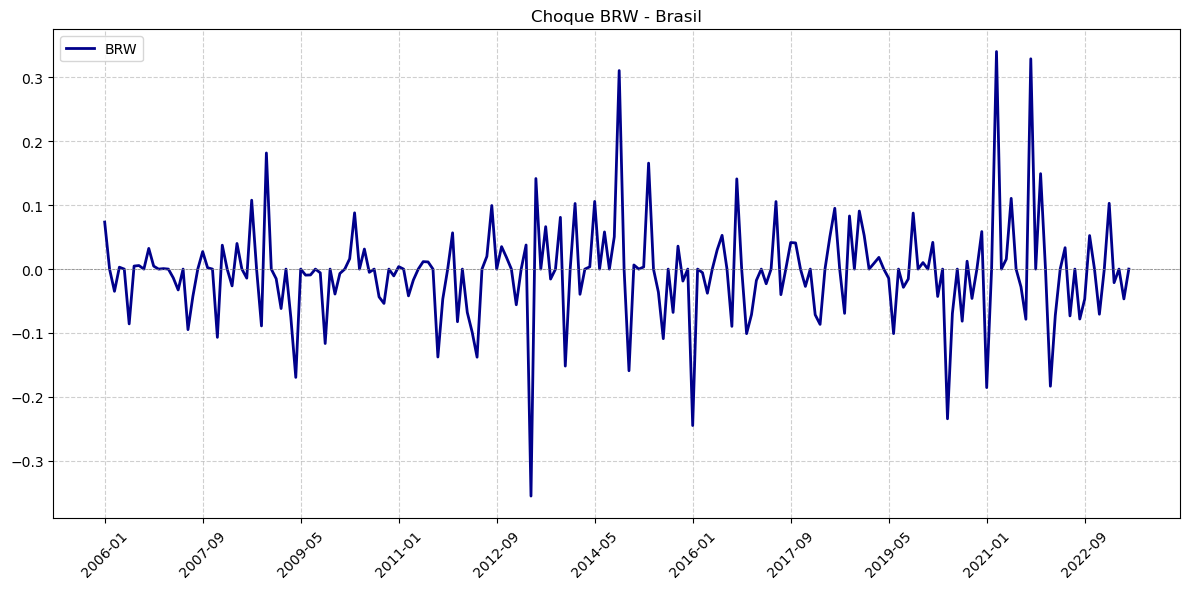

In [29]:
# Converter valores do tipo Period para datetime
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Configuração do estilo do gráfico
plt.figure(figsize=(12, 6))
plt.plot(mdate_values, new_shock_values, color='darkblue', linewidth=2, label='BRW')
plt.title("Choque BRW - Brasil")
#plt.xlabel("Data")
#plt.ylabel("Valor do Choque")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')

# Personalização do eixo x
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45)

# Adicionando grade horizontal
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajustando margens e espaçamento
plt.tight_layout()

# Exibindo o gráfico
plt.show()


### Shock Construction Robustness

In [30]:
### IV2 refers to the BRW shock series aligned using daily movements in the policy indicator 2-days after COPOM announcement day rather than one week as the instrumental variable

data_iv2 = data_complete[data_complete["q"].isin([1, 2])].copy()
step_1(data_iv2,list_maturities,2)
data_iv2 = step_2(data_iv2)
renormalization(data_iv2)

### IV7 refers to the BRW shock series aligned using daily movements in the policy indicator 7-days after COPOM announcement day rather than one week as the instrumental variable

data_iv7 = data_complete[data_complete["q"].isin([1, 3])].copy()
step_1(data_iv7,list_maturities,3)
data_iv7 = step_2(data_iv7)
renormalization(data_iv7)

### R5 refers to the BRW shock series aligned using zero-coupon yields with only the 1, 2, 5, 10, 30-year maturities as outcome variables

list_maturities_R5 = ["01", "02", "05", "10", "30"]
data_R5 = data_brw[["date","dgs_d","q","mdate", "SVENY01_d","SVENY02_d", "SVENY05_d", "SVENY10_d", "SVENY30_d"]]
step_1(data_R5,list_maturities_R5,0)
data_R5 = step_2(data_R5)
renormalization(data_R5)

### R10 refers to the BRW shock series aligned using zero-coupon yields with only the 1 to 10-year maturities as outcome variables

list_maturities_R10 = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
data_R10 = data_brw[["date","dgs_d","q","mdate", "SVENY01_d","SVENY02_d", "SVENY03_d","SVENY04_d","SVENY05_d","SVENY06_d","SVENY07_d","SVENY08_d","SVENY09_d", "SVENY10_d"]]
step_1(data_R10,list_maturities_R10,0)
data_R10 = step_2(data_R10)
renormalization(data_R10)

### Day2 refers to the BRW shock series aligned using a 2-day event window around COPOM announcement days

data_day2 = data_brw
for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name] - yield_data[col_name].shift(2)
selected_columns = yield_data.iloc[:, -30:]
data_day2 = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
step_1(data_day2,list_maturities,0)
data_day2 = step_2(data_day2)
renormalization(data_day2)


columns_2 = data_iv2[['mdate', 'BRW_daily']]
columns_2.isetitem(columns_2.columns.get_loc('mdate'), columns_2['mdate'].dt.strftime('%Y-%m'))

columns_7 = data_iv7[['mdate', 'BRW_daily']]
columns_7.isetitem(columns_7.columns.get_loc('mdate'), columns_7['mdate'].dt.strftime('%Y-%m'))

columns_R5 = data_R5[['mdate', 'BRW_daily']]
columns_R5.isetitem(columns_R5.columns.get_loc('mdate'), columns_R5['mdate'].dt.strftime('%Y-%m'))

columns_R10 = data_R10[['mdate', 'BRW_daily']]
columns_R10.isetitem(columns_R10.columns.get_loc('mdate'), columns_R10['mdate'].dt.strftime('%Y-%m'))

columns_day2 = data_day2[['mdate', 'BRW_daily']]
columns_day2.isetitem(columns_day2.columns.get_loc('mdate'), columns_day2['mdate'].dt.strftime('%Y-%m'))

data_monthly = data_monthly.merge(columns_2, on='mdate', how='left', suffixes=['', '_iv2'])
data_monthly['BRW_daily_iv2'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_7, on='mdate', how='left', suffixes = ['', '_iv7'])
data_monthly['BRW_daily_iv7'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_R5, on='mdate', how='left', suffixes = ['', '_R5'])
data_monthly['BRW_daily_R5'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_R10, on='mdate', how='left', suffixes = ['', '_R10'])
data_monthly['BRW_daily_R10'].fillna(0, inplace=True)
data_monthly = data_monthly.merge(columns_day2, on='mdate', how='left', suffixes = ['', '_day2'])
data_monthly['BRW_daily_day2'].fillna(0, inplace=True)





                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                     -1.4038
Estimator:                    IV-2SLS   Adj. R-squared:                -1.4125
No. Observations:                 278   F-statistic:                    7.0806
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.0078
Time:                        17:23:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0091     0.0136     0.6733     0.5008     -0.0175      0.0358
dgs_d          2.0490     0.7700     2.6609     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY12_d   R-squared:                     -0.0254
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0291
No. Observations:                 278   F-statistic:                    0.9961
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.3182
Time:                        17:23:22   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0249     0.0092     2.7116     0.0067      0.0069      0.0429
dgs_d          0.2830     0.2836     0.9981     0.31

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY23_d   R-squared:                     -0.0016
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0052
No. Observations:                 278   F-statistic:                    0.0043
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.9479
Time:                        17:23:22   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0228     0.0102     2.2389     0.0252      0.0028      0.0428
dgs_d          0.0215     0.3299     0.0653     0.94

C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.1420
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1389
No. Observations:                 278   F-statistic:                    34.067
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.0000
Time:                        17:23:22   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0052     0.0070    -0.7363     0.4615     -0.0190      0.0086
dgs_d          1.4262     0.2443     5.8367     0.00

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY12_d   R-squared:                     -0.0006
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0042
No. Observations:                 278   F-statistic:                    0.0001
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.9916
Time:                        17:23:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0074     0.0084     0.8818     0.3779     -0.0091      0.0240
dgs_d         -0.0020     0.1940    -0.0105     0.99

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY23_d   R-squared:                     -0.0285
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0322
No. Observations:                 278   F-statistic:                    0.6691
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.4134
Time:                        17:23:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0092     0.0099     0.9304     0.3521     -0.0102      0.0287
dgs_d         -0.1948     0.2381    -0.8180     0.41

C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.7003
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6981
No. Observations:                 139   F-statistic:                    1752.3
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.0000
Time:                        17:23:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0035     0.0079    -0.4386     0.6609     -0.0190      0.0121
dgs_d          0.9755     0.0233     41.860     0.00

C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1539200891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["const"] = 1
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1539200891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.7003
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6981
No. Observations:                 139   F-statistic:                    1752.3
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.0000
Time:                        17:23:24   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0035     0.0079    -0.4386     0.6609     -0.0190      0.0121
dgs_d          0.9755     0.0233     41.860     0.00

C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alys

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                      0.3514
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3491
No. Observations:                 278   F-statistic:                    25.044
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.0000
Time:                        17:23:24   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0032     0.0080    -0.4020     0.6877     -0.0189      0.0125
dgs_d          1.2933     0.2584     5.0044     0.00

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY09_d   R-squared:                     -0.1329
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1370
No. Observations:                 278   F-statistic:                    0.6102
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.4347
Time:                        17:23:24   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const       9.574e-05     0.0158     0.0061     0.9952     -0.0309      0.0311
dgs_d         -0.4439     0.5682    -0.7812     0.43

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY17_d   R-squared:                     -0.1333
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1374
No. Observations:                 278   F-statistic:                    1.2169
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.2700
Time:                        17:23:25   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0095     0.0185    -0.5152     0.6064     -0.0457      0.0267
dgs_d         -0.7269     0.6589    -1.1032     0.27

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY24_d   R-squared:                     -0.0986
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1026
No. Observations:                 278   F-statistic:                    1.2372
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.2660
Time:                        17:23:25   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0143     0.0204    -0.7037     0.4816     -0.0543      0.0256
dgs_d         -0.8034     0.7223    -1.1123     0.26

C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmodels\iv\model.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(
C:\Users\Alysson\anaconda3\Lib\site-packages\linearmode

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY30_d   R-squared:                     -0.0788
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0827
No. Observations:                 278   F-statistic:                    1.1794
Date:                Tue, Oct 17 2023   P-value (F-stat)                0.2775
Time:                        17:23:25   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0169     0.0217    -0.7797     0.4355     -0.0593      0.0256
dgs_d         -0.8309     0.7651    -1.0860     0.27

C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = aligned_dgs_d.copy()
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "new_shock"] = dataframe["new_shock"].apply(lambda x: x[0])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_14908\1197651082.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

In [31]:
data_monthly

,mdate,BRW_daily,BRW_daily_iv2,BRW_daily_iv7,BRW_daily_R5,BRW_daily_R10,BRW_daily_day2
0,2006-01,0.073583,0.078393,0.077005,0.040127,-0.004032,0.058962
1,2006-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2006-03,-0.034759,-0.033431,-0.033822,-0.037867,-0.038468,-0.022126
3,2006-04,0.002962,0.005697,0.004909,-0.012639,-0.021491,-0.246398
4,2006-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
205,2023-02,0.102943,0.097907,0.099407,0.120478,0.129054,0.049681
206,2023-03,-0.021251,-0.023384,-0.022780,-0.006256,-0.000973,0.001162
207,2023-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208,2023-05,-0.046660,-0.048233,-0.047808,-0.032702,-0.028439,-0.003944


In [32]:

robustness = {
    'iv2': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_iv2']), "Using dly movements in the policy indicator 2-days after COPOM announcement day as IV"],
    'iv7': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_iv7']), "Using dly movements in the policy indicator 7-days after COPOM announcement day as IV"],
    'R5': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_R5']), "Using yields with only the 1, 2, 5, 10, 30-year maturities as outcome variables"],
    'R10': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_R10']), "Using yields with only the 1 to 10-year maturities as outcome variables"],
    'day2': [data_monthly['BRW_daily'].corr(data_monthly['BRW_daily_day2']), "Using a 2-day event window around COPOM announcement days"],

}

rob = pd.DataFrame.from_dict(robustness, orient='index', columns=[['Correlação','Explain']])

# Imprimir o DataFrame
rob

,Correlação,Explain
iv2,0.998853,Using dly movements in the policy indicator 2-...
iv7,0.999412,Using dly movements in the policy indicator 7-...
R5,0.980459,"Using yields with only the 1, 2, 5, 10, 30-yea..."
R10,0.804066,Using yields with only the 1 to 10-year maturi...
day2,0.863888,Using a 2-day event window around COPOM announ...


In [ ]:
subset_data = data_monthly

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)